In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from tensorflow import keras 
import random
random.seed(1234)

/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/

In [2]:
# Our data is a fairly simple linear Model which is binarized for the Neural Net (second example)

X = np.random.rand(100,5)
y = 5.*X[:,0] - 1. * X[:,1] - 0.5*X[:,2] - 4.*X[:,4] + 0.1*np.random.normal(size=100) # X[:,3] is an irrelevant feature
yNN = (y> np.mean(y))*1



In [3]:
print(X[1,:])
print(y[1])

[0.59463124 0.16890424 0.27621103 0.30546533 0.21526508]
1.885962984081072


In [4]:
reg = LinearRegression().fit(X,y)

In [5]:
print(reg.coef_)  # Seems alright!

[ 5.01359898 -0.99999435 -0.46273128 -0.01644311 -4.04154962]


## Let's try to code SHAP for ourselves

In [6]:
p = 5 # Number of Features
n = 100 # Sample size
i = 10 # We want to analyze the ith instance 

We wish to sample from an extreme Beta-Distribution so that we get either very few or very many features. The first case shows the isolatd effect of a feature, the latter the interaction of a feature with all other ones.

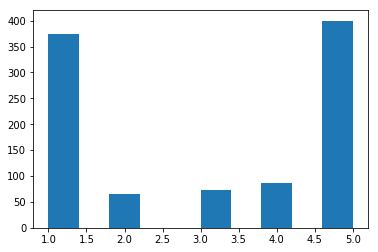

In [7]:
sample = np.random.beta(0.2, 0.2,1000)
sample = sample*5+1
sample = np.floor(sample).astype(int)
plt.hist(sample)
plt.show()

In [8]:
sel = np.random.choice(np.arange(p), size=3, replace=False)
print(sel)
r = np.arange(5)
print(r[sel])
r[sel] = 5
print(r)


[3 2 4]
[3 2 4]
[0 1 5 5 5]


In [9]:
print(sel)
np.sum(sel==1)

[3 2 4]


0

In [10]:
def ChooseK(P):# P is integer of Feature number
    K =np.random.beta(0.2, 0.2,1)
    K = int(P*K+1)
    if K==P+1: # some degenerate cases
        K = K-1
    return(K)

In [11]:
ChooseK(4)

1

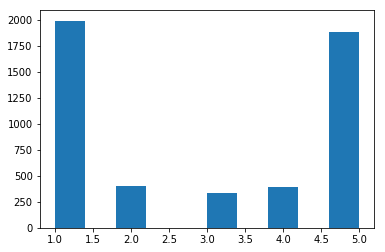

1.0 5.0
[2. 5. 1. ... 5. 1. 5.]


In [12]:
ks = np.empty(5000)
for ll in range(5000):
    ks[ll] =ChooseK(5)
plt.hist(ks)
plt.show()
print(min(ks),max(ks))
print(ks)

In [13]:
def SwapFeatures(i,m,j,k):
    # take instance x_i, exchange k of its features randomly with the features of x_m including the jth Feature
    output = X[i,:].copy()
    
    if k == 1: # only change jth Feature
        output[j] = X[m,j].copy()
    
    else:
        Selection = np.random.choice(np.arange(p), size=k, replace=False)
        while (np.sum(Selection==j) ==0): # Make sure that j is included in selection
            Selection = np.random.choice(np.arange(p), size=k, replace=False)
        
        output[Selection] = X[m,Selection].copy()
    
    return(output)
        
        

In [14]:
print(X[np.arange(4),:])
print(SwapFeatures(2,3,0,2))

[[0.26743609 0.42796657 0.26026435 0.30716661 0.51894332]
 [0.59463124 0.16890424 0.27621103 0.30546533 0.21526508]
 [0.71172737 0.23884992 0.1640222  0.95019868 0.58198794]
 [0.22479202 0.88695937 0.64550784 0.70910082 0.20952642]]
[0.22479202 0.23884992 0.1640222  0.95019868 0.20952642]


In [15]:
def Compare(x_j, x_noj, Model):
    return(Model.predict(x_j.reshape(1, -1)) - Model.predict(x_noj.reshape(1, -1)))

In [16]:
reg.predict(np.arange(5).reshape(1, -1))

array([-18.163276])

In [17]:
def CalcShap(X,i,j,M,Model):
    # Calculate Shap values for DataSet X for ith instance and jth feature with M iterations for AI-Model "Model"
    M_iter = 0 # iteration index
    SHAPValues = np.empty(M)
    
    while M_iter<M:
        m = np.random.randint(X.shape[0]) # random instance to "mix" x_i with
    
        if m!=i:
            k = ChooseK(X.shape[1])
            
            x_dummy_noj = SwapFeatures(i,m,j,k) # sample from random other instance
            x_dummy_j = x_dummy_noj.copy()
            x_dummy_j[j] = X[i,j].copy()  # compare with j and without j
        
            SHAPValues[M_iter] = Compare(x_dummy_j,x_dummy_noj, Model=reg)
        
            M_iter = M_iter+1
            
    return(np.mean(SHAPValues))


In [18]:
def FeatureImportance(X,j,M1,M2,Model):
    # Calculate Feature Importancec over M1 instances for j'th Feature of Data Set X,
    #   compare each instance M2 times and evaluate via Model
    
    Output = np.empty(M1)
    
    for m1 in range(M1):
        i = np.random.randint(X.shape[0])
        Output[m1] = np.abs(CalcShap(X,i,j,M2,Model))
        
    return(np.mean(Output))
        

In [19]:
# Just for the ith instance
SHAPValues_i = np.empty(X.shape[1])
for index in range(X.shape[1]):
    SHAPValues_i[index] = CalcShap(X, i=0, j = index, M = 1000, Model=reg)

In [20]:
# For the entire Data Set
SHAP_Importance = np.empty(5)
for Jf in range(X.shape[1]):
    SHAP_Importance[Jf] = FeatureImportance(X,Jf,100,100,reg)
    print(Jf, SHAP_Importance[Jf])

0 1.334203982166776
1 0.2533754219431914
2 0.11627794173981741
3 0.004654461564958297
4 1.0835138081059013


## Sanity Checks

We can reproduce the coefficients of the linear model with the SHAP values

In [21]:
SHAPValues_i

array([-1.21862224,  0.05200788,  0.11622132,  0.00288783, -0.12668791])

In [22]:
for index in range(X.shape[1]):
    print(SHAPValues_i[index]/ (X[0,index]-np.mean(X[:,index])))

5.0913924484427415
-1.2001163395383148
-0.4872042401889289
-0.017170694155301352
-3.697120215693432


Very close to the real linear coefficients!

In [23]:
CalcShap(X, 10, 0, 1000, reg)

0.9711563114192397

In [24]:
-2.2819590130308125/(X[10,0]-np.mean(X[:,0]))

-11.351226321468443

In [25]:
SHAP_Importance

array([1.33420398, 0.25337542, 0.11627794, 0.00465446, 1.08351381])

In [26]:
for a in range(5):
    print(SHAP_Importance[a]/np.mean(np.abs(X[:,a]-np.mean(X[:,a]))))

5.438941085778978
0.9837502391660632
0.43334108232486246
0.017563831590175424
4.550226838860607


##### These are reasonably close to the absolute values of the linear model!

## Now with a Neural Net

In [27]:
# define the keras model
NN = keras.models.Sequential()
NN.add(keras.layers.Dense(12, input_dim=5, activation='relu'))
NN.add(keras.layers.Dense(8, activation='relu'))
NN.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the keras model
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
NN.fit(X[0:50,:],yNN[0:50], epochs=50, batch_size=10)
# evaluate the keras model
_, accuracy = NN.evaluate(X[50:,:], yNN[50:])
print('Accuracy: %.2f' % (accuracy*100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
50/50 [==============================] - 0s 1ms/sample - loss: 0.6814 - acc: 0.6200
Epoch 2/50
50/50 [==============================] - 0s 57us/sample - loss: 0.6777 - acc: 0.6200
Epoch 3/50
50/50 [==============================] - 0s 56us/sample - loss: 0.6749 - acc: 0.6400
Epoch 4/50
50/50 [==============================] - 0s 54us/sample - loss: 0.6714 - acc: 0.6600
Epoch 5/50
50/50 [==============================] - 0s 55us/sample - loss: 0.6679 - acc: 0.6800
Epoch 6/50
50/50 [==============================] - 0s 56us/sample - loss: 0.6641 - acc: 0.7000
Epoch 7/50
50/50 [==============================] - 0s 58us/sample - loss: 0.6606 - acc: 0.7400
Epoch 8/50
50/50 [==============================] - 0s 55us/sample - loss: 0.6566 - acc: 0.7600
Epoch 9/50
50/50 [===

2021-10-26 15:24:10.621183: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-10-26 15:24:10.644660: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3299990000 Hz
2021-10-26 15:24:10.645708: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2e285f0 executing computations on platform Host. Devices:
2021-10-26 15:24:10.645743: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-10-26 15:24:10.680186: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

Epoch 16/50
50/50 [==============================] - 0s 55us/sample - loss: 0.6233 - acc: 0.8000
Epoch 17/50
50/50 [==============================] - 0s 70us/sample - loss: 0.6185 - acc: 0.8000
Epoch 18/50
50/50 [==============================] - 0s 56us/sample - loss: 0.6139 - acc: 0.8200
Epoch 19/50
50/50 [==============================] - 0s 52us/sample - loss: 0.6089 - acc: 0.8400
Epoch 20/50
50/50 [==============================] - 0s 55us/sample - loss: 0.6037 - acc: 0.8400
Epoch 21/50
50/50 [==============================] - 0s 53us/sample - loss: 0.5980 - acc: 0.8400
Epoch 22/50
50/50 [==============================] - 0s 52us/sample - loss: 0.5925 - acc: 0.8400
Epoch 23/50
50/50 [==============================] - 0s 57us/sample - loss: 0.5866 - acc: 0.8400
Epoch 24/50
50/50 [==============================] - 0s 54us/sample - loss: 0.5807 - acc: 0.8800
Epoch 25/50
50/50 [==============================] - 0s 52us/sample - loss: 0.5744 - acc: 0.8800
Epoch 26/50
50/50 [===========

In [28]:
print(NN.predict(X[40:60,:]))
print(yNN[40:60])

[[0.21838164]
 [0.20959753]
 [0.6645434 ]
 [0.21125203]
 [0.7814669 ]
 [0.28546947]
 [0.18685582]
 [0.4414124 ]
 [0.46166456]
 [0.4357135 ]
 [0.8299562 ]
 [0.6643817 ]
 [0.25191867]
 [0.33172885]
 [0.6968841 ]
 [0.74940705]
 [0.7460697 ]
 [0.7189916 ]
 [0.51183414]
 [0.6067112 ]]
[0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1]


#### Now with SHAP

In [29]:
SHAP_Importance_NN = np.empty(5)
for Jf in range(X.shape[1]):
    SHAP_Importance_NN[Jf] = FeatureImportance(X,Jf,100,100,NN)
    print(Jf, SHAP_Importance_NN[Jf])

0 1.317709844356758
1 0.22492306474816978
2 0.12982407104909355
3 0.004051880689513324
4 0.9573579498912698


Ranking makes sense! Importances are very close to the linear Regression case.